# Spritz PSD modeling

We build on `Spritz-timedomain-gap-filling.ipynb` to build/test a PSD modeling approach applicable to Spritz data.

E Castelli 2022
J Baker (NASA-GSFC) 2023

## Table of contents

0. Settings and package import
1. Load and prepare time-domain LDC noise data
2. 
3. Data pre-processing before gap-imputation
4. Gap imputation with custom gaps
    1. noise-only `n` data
    2. noise + signal `n + s` data
5. Analysis of Spritz data

## 0. Settings and package import

In [1]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal
import h5py
import time

In [2]:
# Custom LISA Data Analysis packages 
from ldc.lisa.noise import get_noise_model
from ldc.common import tools
from ldc.common.constants import ldc_cosmo as cosmo
from ldc.common.series import TimeSeries, FrequencySeries, TDI
from ldc.common.tools import compute_tdi_snr, window
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from ldc.waveform.lisabeta import FastBHB

import lisabeta.lisa.ldcnoise as ldcnoise
from bayesdawn import datamodel, psdmodel

MLDC modules could not be loaded.


In [3]:
# define function to print all attributes of hdf5 file recursively
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. In order to do that, we separate the effect of glitches from the effect of gaps in the Spritz data.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [4]:
# import data
fname = './data/LDC2_spritz_mbhb1_training_v1.h5'
# open file with h5py
fid = h5py.File(fname)
# print all dataset attributes
# fid.visititems(print_attrs)

#### 1.1. Import the existing TDI datasets

- TDI dataset `obs` containing `noise + signal + artifacts` (gaps + glitches)
- TDI dataset `clean` containing `noise + signal`
- TDI dataset `sky` containing `signal`
- TDI dataset `noisefree` containing `signal + artifacts` (gaps + glitches)

In [5]:
# load xarray dataset containing TDI combinations from LDC dataset
tdi_ts = fid['obs/tdi'][()].squeeze()
# clean data only noise + signal
tdi_clean = fid["clean/tdi"][()].squeeze()
# no noise no glitches, only signal
tdi_sky = fid["sky/tdi"][()].squeeze()
# no noise only glitches and MBHB data
tdi_nonoise = fid["noisefree/tdi"][()].squeeze()

#### 1.2. Build the missing TDI dataset
- TDI dataset containing `noise`

In [6]:
# set up dataset constant values
skip = 100 
# skipb = 100 
ndata = len(tdi_ts[skip:])
dt = tdi_ts['t'][1]-tdi_ts['t'][0]
fs = 1.0/dt

print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
print(skip, ndata, dt, fs,sep='\t')

skip	ndata	dt	fs
------------------------------
100	535580	5.0	0.2


In [7]:
# generate noise-only dataset
tdi_noise = np.copy(tdi_clean)
for tdi in tdi_clean.dtype.names[1:]:
    tdi_noise[tdi] = tdi_clean[tdi] - tdi_sky[tdi]


#### 1.3 Build orthogonal TDI combinations for noise data. 



In [8]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi
datan = build_orthogonal_tdi(tdi_noise)

## 2. Gap imputation with unknown noise

In the above we performed imputation with the benefit of auxiliary information about the noise PSD.  In particular we either started with an analytic PSD model or derived a model based on known "ungapped" data.  Thus, we cheated, as these processes cannot be applied to real gapped data, or the nominal Spritz dataset.

Still working with noise-only data, here we will infer the PSD and the missing data together.  The way we did this in the 2019 paper applied a parameterized model for the PSD which was inferred by Bayesian inference using MCMC. As a simpler first step, here we will apply a maximum likelihood PSD, effectively applying an expectation-maximization algorithm. 

Here we understand "maximum likelihood" loosely.  Generally for Gaussian noise, with unknown covariance, the maximum likelihood covariance is the sample covariance (computed a particular way) of the noise residual. We apply that result only as a rough principle and instead just compute a (in some way) best fit modeled PSD.

Various PSD models may make sense here.  The model could be fit directly to the residual spectrum/PSD or (as is already done above) we can fit to a ratio of the computed PSD over an analytic model.  Different versions of that analytic model can also make sense.  In particular, it may be worthwhile to smooth the dips.  The model function may be, for example, a polyfit or a smoothed spline.  One can also consider whether it makes more sense to fit the PSD (which has approximate zeros), or its inverse (which appears directly in the likelihood computation).

We implement this in a new class ModelFDDataPSD bayesdawn/connect/fillgaps.py. 

Note: Long-term, it probably makes sense to eventually fold the functionality here into the underlying
    bayesdawn.psdmodel.PSD code, which already includes a MCMC sampled spline fit for the PSD. Missing
    there is the crutch we use here for starting from, and scaling against an approximate analytic model.

MLDC modules could not be loaded.


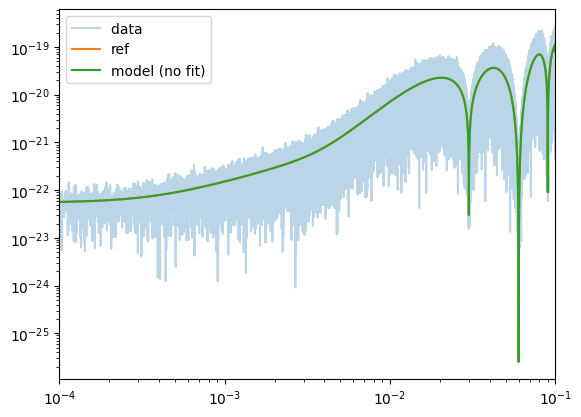

log_poly


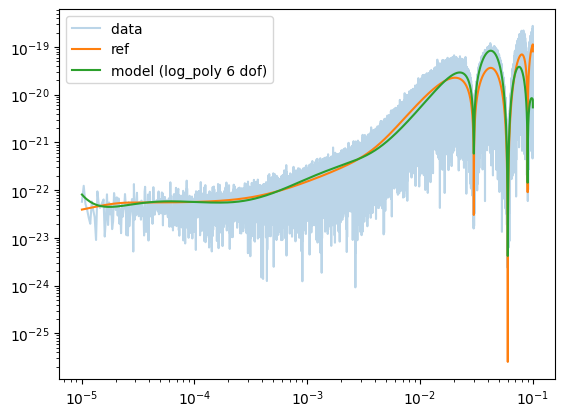

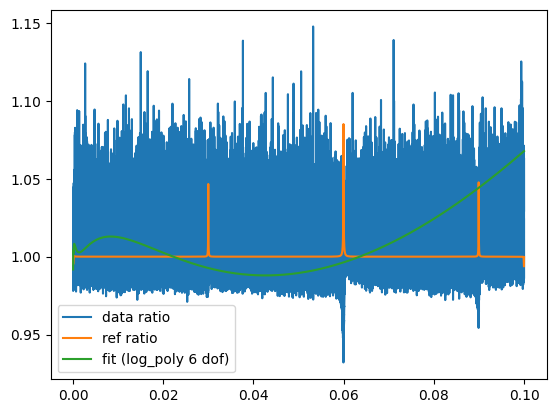

/tmp/ipykernel_1350365/1233151134.py:31: RankWarning: Polyfit may be poorly conditioned
  psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)


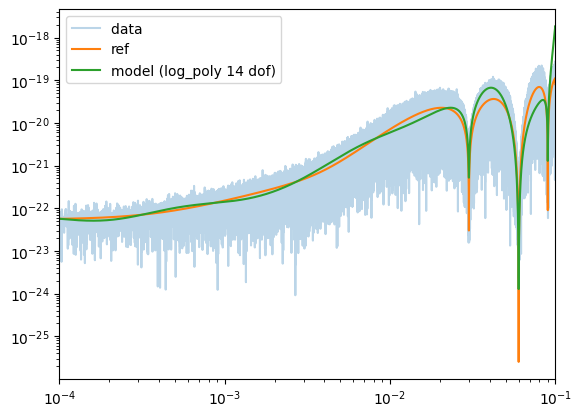

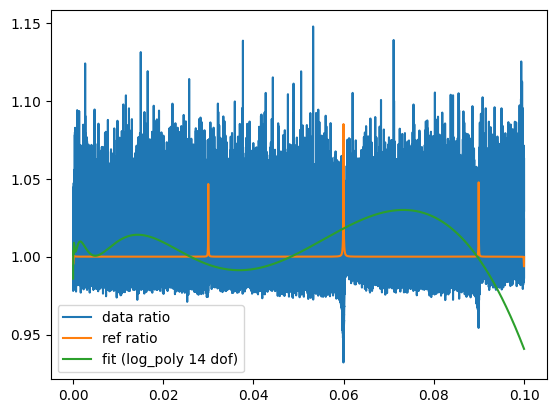

log_spline
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.929564622283716
lowest f knots: [3.70952318e-05 6.99086798e-05 1.30244595e-04 2.39935321e-04
 4.37142640e-04]


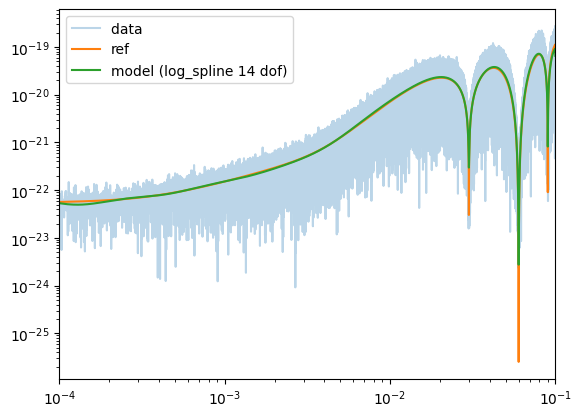

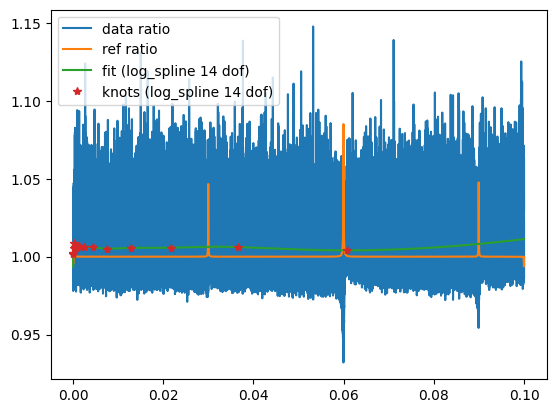

1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.444964653716728
lowest f knots: [2.10052048e-05 3.02187156e-05 4.33790033e-05 6.21359987e-05
 8.88122291e-05]


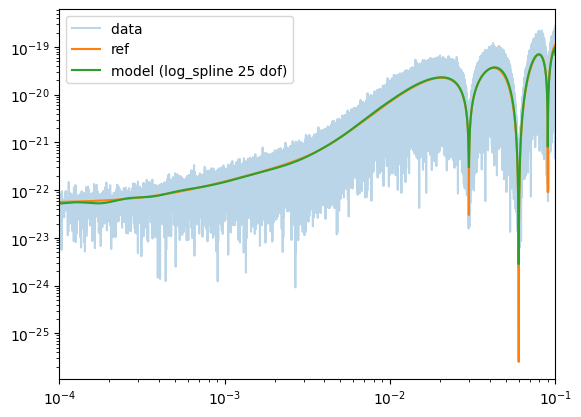

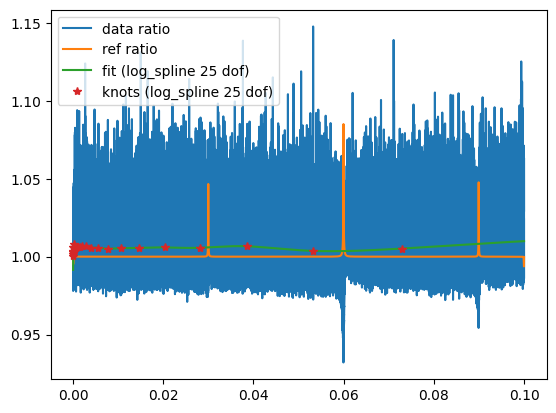

logratio_poly


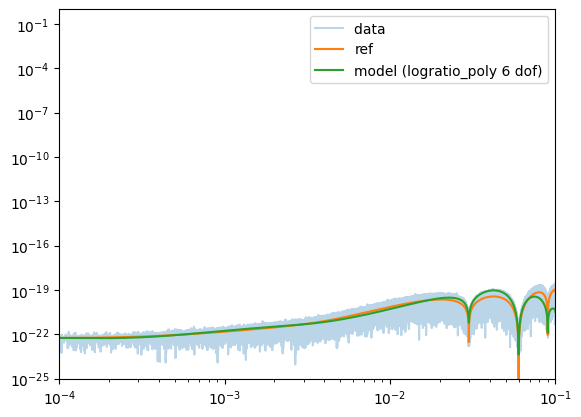

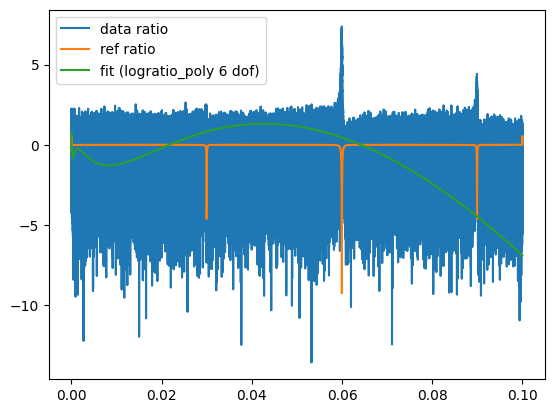

/tmp/ipykernel_1350365/1233151134.py:50: RankWarning: Polyfit may be poorly conditioned
  psdmod=ModelPSD(fd,'A',fit_type='logratio_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)


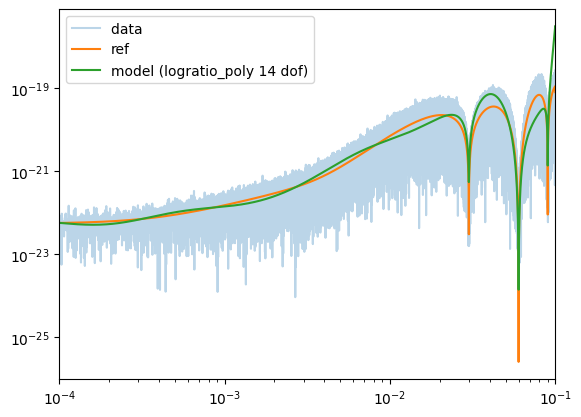

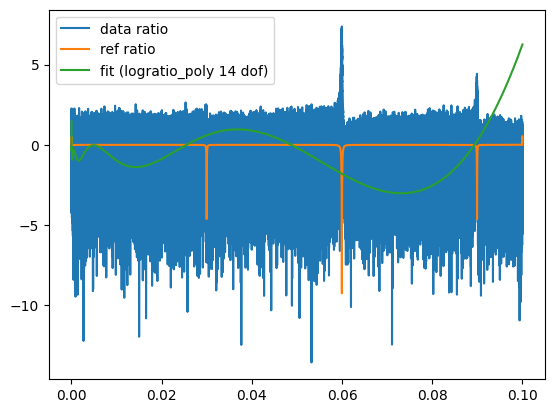

logratio_spline
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.929564622283716
lowest f knots: [3.70952318e-05 6.99086798e-05 1.30244595e-04 2.39935321e-04
 4.37142640e-04]


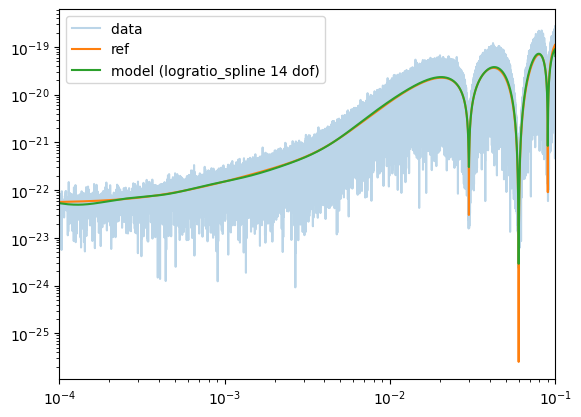

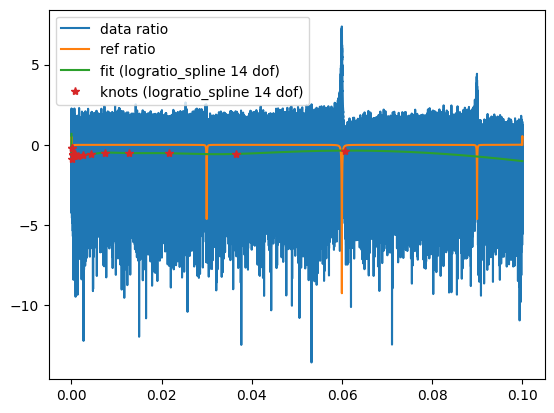

1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.444964653716728
lowest f knots: [2.10052048e-05 3.02187156e-05 4.33790033e-05 6.21359987e-05
 8.88122291e-05]


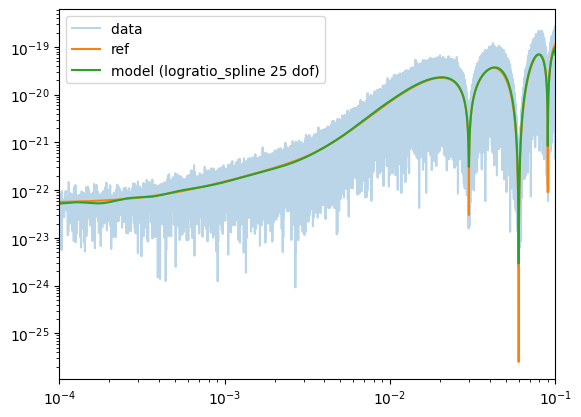

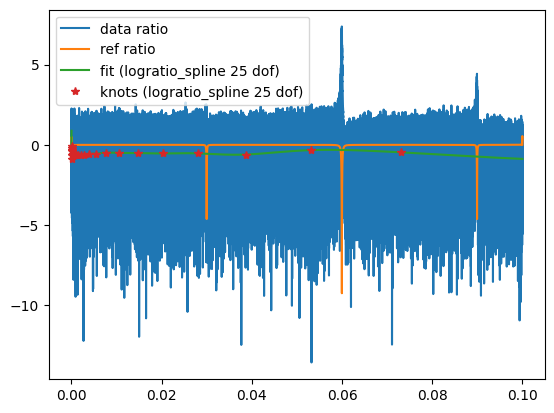

spline no analytic model
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.2586667648311038
lowest f knots: [1.59643549e-05 2.00716736e-05 2.52218757e-05 3.16762186e-05
 3.97605156e-05]
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.1219031887070756
lowest f knots: [1.13116196e-05 1.26896486e-05 1.42345533e-05 1.59664199e-05
 1.79077380e-05]


(0.0001, 0.1)

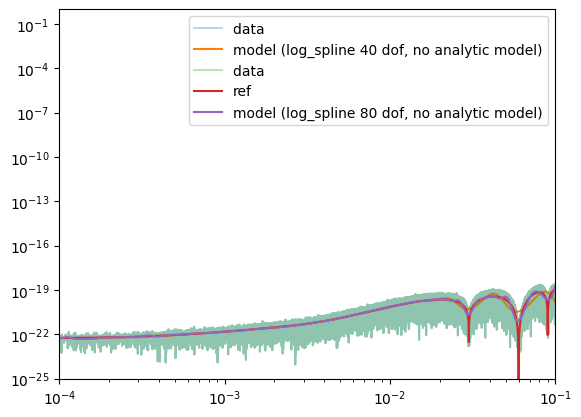

In [9]:
import importlib
import bayesdawn.connect.fillgaps as fillgaps
from bayesdawn import psdmodel
importlib.reload(fillgaps)
importlib.reload(psdmodel)
fd=fillgaps.makeFDdata(datan)
#ModelPSD=ModelFDDataPSD
#ModelPSD=fillgaps.ModelFDDataPSD
ModelPSD=psdmodel.ModelFDDataPSD
show_fit=True
offset_log_fit=True
lims=(None,None)
#lims=(0.029,0.062)
lims=(1e-4,.1)
#psdmod=ModelPSD(fd,'A',fit_type=None,fmin=1e-5)
#psdmod.plot()
#psdmod=ModelPSD(fd,'A',fit_type=None,smooth_df=4e-6,fmin=1e-5)
#psdmod.plot()
ref=psdmod=ModelPSD(fd,'A',fit_type=None,smooth_df=4e-5,fmin=1e-5)
psdmod.plot(ref=ref)
plt.xlim(*lims)
plt.show()
#print('poly')
#psdmod=ModelPSD(fd,'A',fit_type='poly',fit_dof=4,smooth_df=4e-4,fmin=1e-5)
#psdmod.plot(show_fit=show_fit)
print('log_poly')
psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=6,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='log_poly 6 dof',ref=ref)
plt.xlim(*lims)

psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='log_poly 14 dof',ref=ref)
plt.xlim(*lims)

if not show_fit:plt.show()
print('log_spline')
psdmod=ModelPSD(fd,'A',fit_type='log_spline',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='log_spline 14 dof',ref=ref)
plt.xlim(*lims)
psdmod=ModelPSD(fd,'A',fit_type='log_spline',fit_dof=25,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='log_spline 25 dof',ref=ref)
plt.xlim(*lims)
plt.ylim(1e-25,None)

print('logratio_poly')
psdmod=ModelPSD(fd,'A',fit_type='logratio_poly',fit_dof=6,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='logratio_poly 6 dof',ref=ref)
plt.xlim(*lims)

psdmod=ModelPSD(fd,'A',fit_type='logratio_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='logratio_poly 14 dof',ref=ref)
plt.xlim(*lims)

if not show_fit:plt.show()
print('logratio_spline')
psdmod=ModelPSD(fd,'A',fit_type='logratio_spline',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='logratio_spline 14 dof',ref=ref)
plt.xlim(*lims)
psdmod=ModelPSD(fd,'A',fit_type='logratio_spline',fit_dof=25,smooth_df=4e-4,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='logratio_spline 25 dof',ref=ref)
plt.xlim(*lims)
plt.ylim(1e-25,None)

if False:
    print('spline')
    psdmod=ModelPSD(fd,'A',fit_type='spline',fit_dof=40,smooth_df=4e-4,fmin=1e-5)
    psdmod.plot(show_fit=show_fit,tag='spline 40 dof',ref=ref)
    plt.xlim(*lims)
    psdmod=ModelPSD(fd,'A',fit_type='spline',fit_dof=60,smooth_df=4e-4,fmin=1e-5)
    psdmod.plot(show_fit=show_fit,tag='spline 60 dof',ref=ref)
    plt.xlim(*lims)
    plt.ylim(1e-25,None)
    plt.show()
print('spline no analytic model')
psdmod=ModelPSD(fd,'A',fit_type='log_spline',noise_model=None,fit_dof=40,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=False,tag='log_spline 40 dof, no analytic model')
psdmod=ModelPSD(fd,'A',fit_type='log_spline',noise_model=None,fit_dof=80,fmin=1e-5,offset_log_fit=offset_log_fit)
psdmod.plot(show_fit=show_fit,tag='log_spline 80 dof, no analytic model',ref=ref)
plt.xlim(*lims)

### 2.1 Log-PSD fitting issue

In development, we noticed that log-scale functional fits to the data seemed systematically offset (rescaled) from the expected (and correct) PSD.  It was noted that a similar issue is addressed in this paper: https://link.springer.com/book/10.1007/978-0-387-69395-8
(paywall) where it was computed that there is an expected offset by $-\gamma$ (Euler's constant). 

Without access to that paper, we can nonetheless compute theoretical expectations for this difference. Neglecting the functional dependence on frequency, and thus considering a local region, where we can imagine that the regions points are draws from a common normal distribution.  We can compute the difference between the expected values $E[|z|^2]$ and $E[\ln(|z|^2)]$. Where $z$ here is complex.

Concretely, and for simplicity, we first assume $z=z_r+iz_i$ with $z_r,z_i\sim N(0,1)$. Since $z_r$ and $z_i$ are independent and have unit variance, it is easy to compute that $E[|z|^2]=E[z_r^2]+E[z_i^2]=2$. 

Next, consider the random variable $x=|z|^2$, the sum of squares of two independent random variables.  The distribution corresponding to sums of squares of normal variables is a well-known chi-squared distribution, in this case with $k=2$ degrees of freedom, with PDF:

$$
p(x|k)=\frac{x^{k/2-1}}{2^{k/2}\Gamma(k/2)}e^{-x/2}
$$

which can be writen in exponential form

$$
p(x|k)=h(x)\exp\left(\eta(k)T(x)-A(\eta(k))\right)
$$
with $h(x)=\exp(-x/2)$, $\eta(k)=k/2-1$, $T(x)=\ln x$, and $A(\eta)=\ln \Gamma(\eta+1)+(\eta+1)\ln2$. A property of the exponential family is that the expected values for the "suffcient statistics", $T(x)$ are easy to compute. Take the derivative of the PDF with respect to $\eta$ and then integrate over $x$. The result shows that
$$
E[T]=\frac{\partial A}{\partial \eta}.
$$
This is a general property of the distributions in the exponential family, which more broadly allow more than one sufficient statistic so that $\eta$ and $T$ are vectors contracted together in the expression.  Then this result applies for each of the sufficient statistics paired with their corresponding $\eta$ components. 

Returning to the chi-squared case, though, the result becomes
$$
E[\ln x]=\psi(\eta+1)+\ln2
$$
where $\psi(\nu)$ is the digamma function the derivative of the log of the $\Gamma$-function.

Even more specifically, when $k=2$, so $\eta=0$, and returning to our original variable $z$, we get
$$
E[\ln( |z|^2)] = \psi(1)+\ln2\\
=-\gamma+\ln2
$$
where $\gamma$ is, again, Euler's constant.

Now, comparing with the non-log mean, we note
$$
E[\ln( |z|^2)]-\ln E[|z|^2]=-\gamma
$$
which is presumably the original result.

These calculations are for unit normal distributions, for clarity we can quickly derive explicit results for non-unit Gaussians, by replacing $z\rightarrow y/\sigma$ then $y_r,y_i\sim N(0,\sigma)$ and we get:
$$
\begin{align}
E[|y|^2]&=2\sigma^2\\
E[\ln( |y|^2)]&=-\gamma+\ln2+2\ln\sigma\\
E[\ln( |y|^2)]-\ln E[|y|^2]&=-\gamma.
\end{align}
$$
No surprise, but this shows that the scaling is unaffected.

The following plots show the effect of the offset

log_poly


/tmp/ipykernel_1350365/3368575689.py:13: RankWarning: Polyfit may be poorly conditioned
  psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=True)
/tmp/ipykernel_1350365/3368575689.py:15: RankWarning: Polyfit may be poorly conditioned
  psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=False)


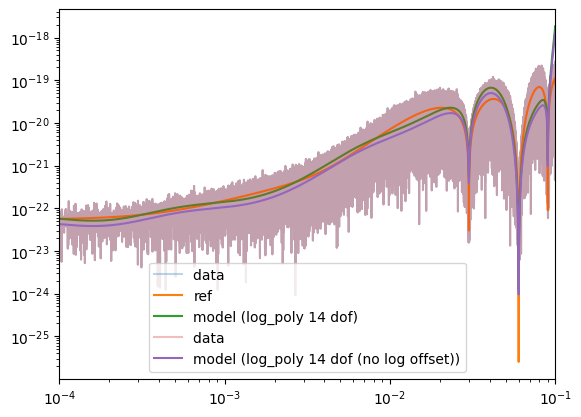

log_spline
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.444964653716728
lowest f knots: [2.10052048e-05 3.02187156e-05 4.33790033e-05 6.21359987e-05
 8.88122291e-05]
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.444964653716728
lowest f knots: [2.10052048e-05 3.02187156e-05 4.33790033e-05 6.21359987e-05
 8.88122291e-05]


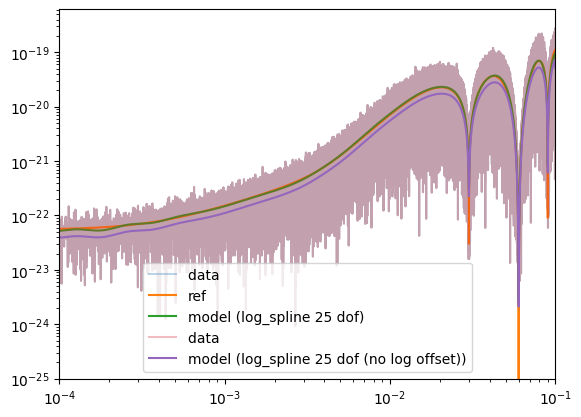

logratio_poly


/tmp/ipykernel_1350365/3368575689.py:31: RankWarning: Polyfit may be poorly conditioned
  psdmod=ModelPSD(fd,'A',fit_type='logratio_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=True)
/tmp/ipykernel_1350365/3368575689.py:33: RankWarning: Polyfit may be poorly conditioned
  psdmod=ModelPSD(fd,'A',fit_type='logratio_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=False)


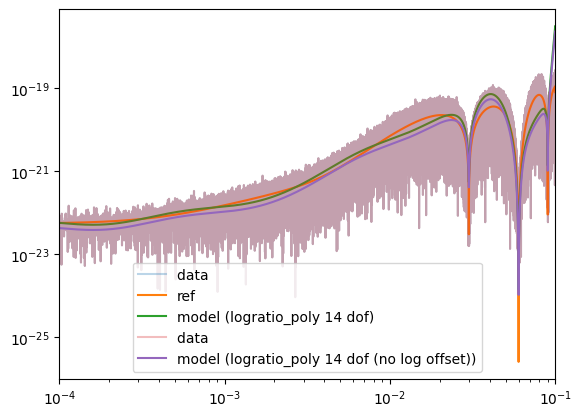

logratio_spline
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.444964653716728
lowest f knots: [2.10052048e-05 3.02187156e-05 4.33790033e-05 6.21359987e-05
 8.88122291e-05]
1.0082527353523284e-05 < f <  0.1 fmin/fmax= 1e-05 None
base= 1.444964653716728
lowest f knots: [2.10052048e-05 3.02187156e-05 4.33790033e-05 6.21359987e-05
 8.88122291e-05]


(1e-25, 6.230413721268514e-19)

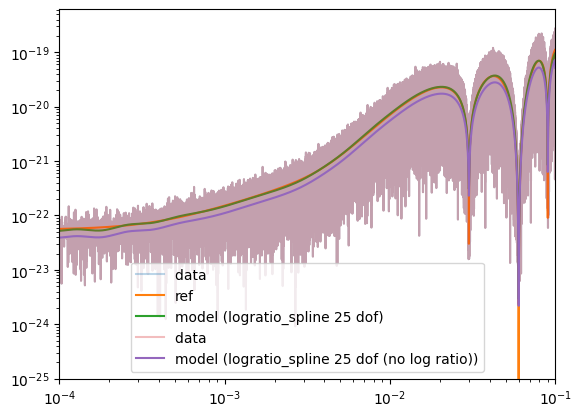

In [11]:
import importlib
import bayesdawn.connect.fillgaps as fillgaps
importlib.reload(fillgaps)
fd=fillgaps.makeFDdata(datan)
#ModelPSD=ModelFDDataPSD
ModelPSD=psdmodel.ModelFDDataPSD
show_fit=False
lims=(None,None)
#lims=(0.029,0.062)
lims=(1e-4,.1)

print('log_poly')
psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=True)
psdmod.plot(show_fit=show_fit,tag='log_poly 14 dof',ref=ref)
psdmod=ModelPSD(fd,'A',fit_type='log_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=False)
psdmod.plot(show_fit=show_fit,tag='log_poly 14 dof (no log offset)')
plt.xlim(*lims)
plt.show()


print('log_spline')
psdmod=ModelPSD(fd,'A',fit_type='log_spline',fit_dof=25,smooth_df=4e-4,fmin=1e-5,offset_log_fit=True)
psdmod.plot(show_fit=show_fit,tag='log_spline 25 dof',ref=ref)
psdmod=ModelPSD(fd,'A',fit_type='log_spline',fit_dof=25,smooth_df=4e-4,fmin=1e-5,offset_log_fit=False)
psdmod.plot(show_fit=show_fit,tag='log_spline 25 dof (no log offset)')
plt.xlim(*lims)
plt.ylim(1e-25,None)
plt.show()

print('logratio_poly')
psdmod=ModelPSD(fd,'A',fit_type='logratio_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=True)
psdmod.plot(show_fit=show_fit,tag='logratio_poly 14 dof',ref=ref)
psdmod=ModelPSD(fd,'A',fit_type='logratio_poly',fit_dof=14,smooth_df=4e-4,fmin=1e-5,offset_log_fit=False)
psdmod.plot(show_fit=show_fit,tag='logratio_poly 14 dof (no log offset)')
plt.xlim(*lims)
plt.show()

print('logratio_spline')
psdmod=ModelPSD(fd,'A',fit_type='logratio_spline',fit_dof=25,smooth_df=4e-4,fmin=1e-5,offset_log_fit=True)
psdmod.plot(show_fit=show_fit,tag='logratio_spline 25 dof',ref=ref)
psdmod=ModelPSD(fd,'A',fit_type='logratio_spline',fit_dof=25,smooth_df=4e-4,fmin=1e-5,offset_log_fit=False)
psdmod.plot(show_fit=show_fit,tag='logratio_spline 25 dof (no log ratio)')
plt.xlim(*lims)
plt.ylim(1e-25,None)

